<a href="https://colab.research.google.com/github/Fengkai-Wei/CPho2023/blob/main/Matrix_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install plotly==4.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import random
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.animation as animation
from matplotlib import rc

rc('animation', html='jshtml')
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**256



# **Declaration of Global Variables:**


1.   Stack of Bragg layers
2.   Incident Wavelength: 1000 nm
3.   Light Speed $3 \times 10^{8} \text{ms}^{-1}$
4.   Predefined Permittivities(Refractive Indices)
  *   Substrate
  *   Layer 1
  *   Layer 2
  *   Cladding

5.   Thicknesses of two layers
6.   Number of Bragg Layer pairs







In [4]:
# Bragg Stack
Stacking_list = list()


# Incident Wavelength /nm
WL = 1000


# Light Speed /ms^-1
C_0 = 3e8

# Refractive Indexes/
n_subs = 1.0
n_1 = 1.5
n_2 = 3.9
n_clad = 1.5
# Permitivities /
eps_subs = pow(n_subs, 2.0)
eps_1 = pow(n_1, 2.0)
eps_2 = pow(n_2, 2.0)
eps_clad = pow(n_clad, 2.0)

# Thickness
d_1 = 130
d_2 = 50

N_pairs = 5




# **Creation of 2 Classes: Light and Stack Layer**

1. Light, with following instances:
  * mode: Polarisation of light, only two options TE and TM. The default value is TE.
  * angle: Incident angle w.r.t. the Normal of Bragg stack, ranging from $-90^{\circ}$ to $90^{\circ}$.
  * F,G: Two complex fields of combined expression of TE and TM.
  * wl: The wavelength of incident light.

2. Stack, with following instances:
  * eps: The permitivity of given material.
  * thickness: The thickness of certian stack layer.



In [5]:
# Definition of two classes: Light and Stack
class Light:
  def __init__(self, mode, angle, F, G, wl):
    self.mode = mode
    self.angle = angle
    self.F = F
    self.G = G
    self.wl = wl

class Stack:
  def __init__(self, eps, thickness):
    self.eps = eps
    self.thickness = thickness


In [26]:
# Add Stack Function

def add_stack(eps_at_WL: float = 1.0, thickness = 1.0):
  ''' Add a layer with given permitivity and thickness.
  Parameters
  ----------
  thickness : non-negative float or string begin with '@'
  Thicknesses of the layers. It accepts two inputs. For float input, the thickness will be that factor times a quarter of optical path.
  E.g. add_stack(1.0, thickness = 2.2)
  The thickness would be 2.2 * WL/(4 * sqrt(eps_at_WL)).

  eps_at_WL : float
  Relative dielectric permittivity of the layers.
  '''

  if eps_at_WL >= 0:
    pass
  else:
    ERROR = f"The value of epsilon: {eps_at_WL} is invalid. The epsilon must be a positive float number."
    return ERROR

  if isinstance(thickness, str) and thickness[0] == '@':
    thickness = float(thickness[1:])*1e-9
  elif thickness >= 0.0:
    thickness = (thickness)*WL*1e-9/(4.0*np.sqrt(eps_at_WL))
  else:
    ERROR = f"The value of thickness: {thickness} is invalid. The thickness can be either a absolute value begins with char '@', or a float factor w.r.t. a quarter wavelength inside the material. "
    return ERROR
    
  global Stacking_list
  Stacking_list.append(Stack(eps = eps_at_WL, thickness = thickness))



# Create Light Klass
# *** The Wavelength should be in unit of NANOMETER! ***
def create_light(mode: str = "TE" or "TM", angle: float = 0.0, F: float = 100.0, G: float = 100.0, wl = float):
  ''' Add a Light with given properties.
  Parameters
  ----------
  mode: non-negative float or string begin with '@'
  Thicknesses of the layers. It accepts two inputs. For float input, the thickness will be that factor times a quarter of optical path.

  eps_at_WL : float
  Relative dielectric permittivity of the layers.

  angle: float
  Incident angle w.r.t. Normal of Bragg stack. Normally only values in range (-90,90) are physically meaningful. Values outside this range still acceptable, however may leads to weird perfomance.

  F,G: float
  Incident complex field of light, the default values are 100.0 and 100.0.

  wl: float
  The wavelength of light, here for simplicity, should have unit of nanometer.

  Returns
  -------
  new_light : Light
  The created Light class
  '''

  # And here the unit is changed into METER for further computation.
  new_light = Light(mode=mode, angle=angle, F=F, G=G, wl=wl*1e-9)

  return new_light
  


In [7]:
# Drude Model of Dispersion

def drude_relation(eps_from_wl, to_wl, from_wl):
  eps_to_wl = 1.0 - (((1 - eps_from_wl) * pow((C_0/(2*np.pi*from_wl)),2))/pow((C_0/(2*np.pi*to_wl)),2))
  return eps_to_wl



$ϵ_e = ϵ_0 (1-\frac{\omega_p^2}{ω^2})\\ ϵ_{er}(ω) = 1-\frac{\omega_p^2}{ω^2} \\ ω_p^2 = \omega^2(1-ϵ_{er}(ω)) $

In [8]:
np.sqrt(drude_relation(eps_from_wl = 2.25, to_wl = 900, from_wl = WL))

1.4186260959111108

In [9]:
# Travelling by Matrix Function
def M_matrix(stack_list=list, light=Light):

  '''Computes the transfer matrix for a given stratified medium.
  Parameters
  ----------
  stack_list : list
  The Bragg stack list.

  light : Light
  The incident light class for computation.


  Returns
  -------
  M_hat : 2d-array
  The transfer matrix of the medium.
  '''



  M_hat = np.identity(2)
  wl = light.wl
  if len(stack_list) != 0:
    for stack in stack_list:
      stack_eps = stack.eps
      #stack_eps = drude_relation(stack.eps, wl*1e9, WL)

      if light.mode == "TE":
        alpha_i = 1.0
      elif light.mode == "TM":
        alpha_i = 1.0/stack_eps
        
      

      kx = (2*np.pi*np.sqrt(stack_eps)*np.cos(np.radians(light.angle)))/(wl)
      d_i = stack.thickness 

      """      
      print(f'eps = {stack.eps}\n')    
      print(f'eps_eff = {stack_eps}\n')
      print(f'wl = {wl*1e9}\n')
      print(f'WL = {WL}\n')
      print(f'kx = {kx}\n')
      
      print(f'thickness = {stack.thickness},\nd_i = {d_i}\n')
      """
      #(f'phase = {kx * d_i / np.pi}Pi\n')
      

      m_hat = np.array([[np.cos(kx * d_i), (np.sin(kx * d_i))/(alpha_i * kx)],
                        [- alpha_i * kx * np.sin(kx * d_i), np.cos(kx * d_i)]])
      M_hat = np.matmul(m_hat,M_hat)

  return M_hat

In [28]:
# Empty the Stacking List

def empty_stack():
  '''Empty the stack list of Bragg stack.
  '''
  global Stacking_list

  Stacking_list.clear()


In [27]:
# Matrix Calculation by Stacks
def stack_calculation(M_hat, light=Light):
  '''Computes the transfer matrix for a given stratified medium.
  Parameters
  ----------
  M_hat : 2-d array
  The Transfer matrix calculated by Bragg stack.

  light : Light
  The incident light class for computation.


  Returns
  -------
  light_cal : Light
  The tranmistted Light class after the stack.
  '''
  input = np.array([light.F, light.G]).reshape(-1,1)
  F,G = np.matmul(M_hat, input)
  light_cal = Light(mode = light.mode, angle = light.angle, F = float(F), G = float(G), wl = light.wl)
  return light_cal




In [29]:
# Transmission Coefficient, Reflection Coefficient and Energy fluxes

def T_R_rho_tau(stack_list=list, light=Light, eps_subs=float, eps_clad=float):
  '''Computes the reflection/transmission coefficient and reflectivity/transmissivity a stratified medium.
  Parameters
  ----------
  stack_list : list
  The Bragg stack list.

  light : Light
  The incident light class for computation.

  eps_subs: float
  The permitivity of substrate.

  eps_clad: float
  The permitivity of cladding.

  Returns
  -------
  tau : 1d-array
  Transmissivity
  rho : 1d-array
  Reflectivity
  T : 1d-array
  Transmission coefficient 
  R : 1d-array
  Reflection coefficient 


  '''




  wl = light.wl
  # The substrate and cladding are assumed to be vacuum, no dispersion. Otherwise uncomment the following codes

  #eps_subs = drude_relation(eps_subs, wl, WL*1e-9)
  #eps_clad = drude_relation(eps_clad, wl, WL*1e-9)



  if light.mode == "TE":
    alpha_s = alpha_c = 1.0
  elif light.mode == "TM":
    alpha_s = 1.0/eps_subs
    alpha_c = 1.0/eps_clad

  else:
    ERROR = "ssss"
    return ERROR
  
  kx_s = (2*np.pi*np.sqrt(eps_subs)*np.cos(np.radians(light.angle)))/(wl)
  kx_c = (2*np.pi*np.sqrt(eps_clad)*np.cos(np.radians(light.angle)))/(wl)

  M_hat = M_matrix(stack_list = stack_list, light = light)

  N = alpha_s * kx_s * float(M_hat[1][1]) + alpha_c * kx_c * float(M_hat[0][0]) + 1j*(M_hat[1][0] - alpha_s *  kx_s * alpha_c * kx_c * float(M_hat[0][1]))
  N_primed = alpha_s * kx_s * float(M_hat[1][1]) - alpha_c * kx_c * float(M_hat[0][0]) - 1j*(M_hat[1][0] + alpha_s *  kx_s * alpha_c * kx_c * float(M_hat[0][1]))
  R = N_primed / N
  T = (2 * alpha_s * kx_s) / N
  rho = pow(np.absolute(R),2)
  tau = (pow(np.absolute(T),2) * alpha_c * np.real(kx_c)) / (alpha_s * np.real(kx_s))

  return np.array([T,R,rho,tau])

In [13]:
# Test function: add_stack

for i in range(1):
  add_stack(eps_1, f'@{d_1}')
  add_stack(eps_2, f'@{d_2}')



for i in Stacking_list:
  print(f"Stack {Stacking_list.index(i)+1}: epsilon = {i.eps}, thickness = {i.thickness} \n")

# Test function: create_light
temp_light = create_light(mode = "TE", F = 1.0, G = 1.0, wl = 1000)

# Test function: M_matrix
temp_m = M_matrix(stack_list = Stacking_list, light = temp_light)
print(f"The propagation matrix M hat: \n {temp_m} \n")

# Test function: stack_calculation
temp_t_light = stack_calculation(M_hat = temp_m, light = temp_light)

print(f"F_{len(Stacking_list)}: {temp_t_light.F/temp_light.F}*F_0, \nG_{len(Stacking_list)}: {temp_t_light.G/temp_light.G}*G_0\n")
empty_stack()


Stack 1: epsilon = 2.25, thickness = 1.3e-07 

Stack 2: epsilon = 15.209999999999999, thickness = 5.0000000000000004e-08 

The propagation matrix M hat: 
 [[-2.25739937e-01  4.68226979e-08]
 [-1.08136432e+07 -2.18692384e+00]] 

F_2: -0.22573989048361748*F_0, 
G_2: -10813645.413372291*G_0



In [14]:
for i in range(5):
  add_stack(eps_1, f'@{d_1}')
  add_stack(eps_2, f'@{d_2}')

# Test function: T_R_rho_tau
T,R,rho,tau = (T_R_rho_tau(stack_list = Stacking_list, light = create_light(mode = "TE", wl = 800), eps_subs = 1.0, eps_clad = 1.0))
print(f"T: {T},\nR: {R},\nrho: {np.real(rho)},\ntau: {np.real(tau)}\n")
empty_stack()


T: (-0.016912969701838004+0.0019023253586687256j),
R: (0.9816272634373125-0.19004801575040794j),
rho: 0.9997103326140945,
tau: 0.00028966738590552446



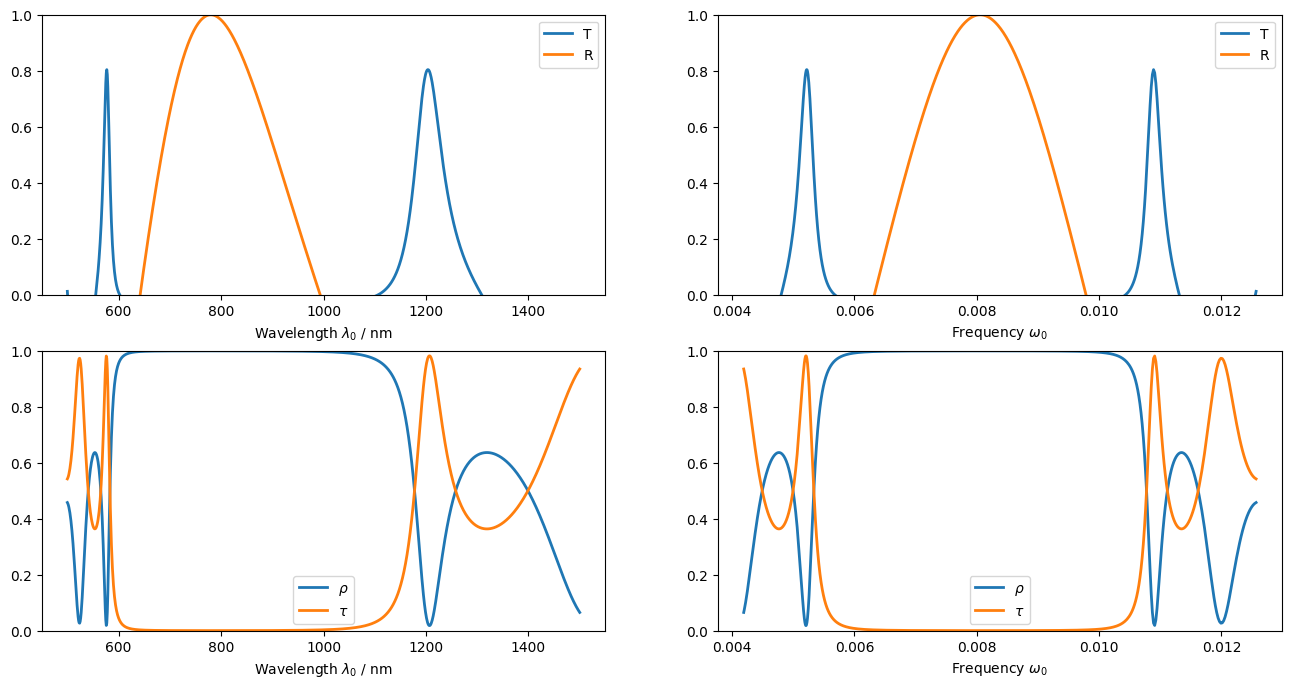

In [31]:
for i in range(N_pairs):
  add_stack(eps_1, f'@{d_1}')
  add_stack(eps_2, f'@{d_2}')

T_list = []
R_list = []
rho_list = []
tau_list = []

x = np.linspace(WL*0.5, WL*1.5, num=1001)


for wl in x:

  T,R,rho,tau = np.real(T_R_rho_tau(stack_list = Stacking_list, light = create_light(mode = "TE", wl = wl), eps_subs = eps_subs, eps_clad = eps_clad))
  T_list.append(T)
  R_list.append(R)
  rho_list.append(rho)
  tau_list.append(tau)
empty_stack()

omega_list = (2 * np.pi)/x



# plot
fig, ax = plt.subplots(nrows=2,ncols=2,figsize = (16,8))



ax[0][0].plot(x, np.array(T_list), label = "T", linewidth=2.0)
ax[0][0].plot(x, np.array(R_list), label = "R", linewidth=2.0)
ax[0][0].legend()

ax[0][0].set(ylim = [0.0,1.0],
       xlabel = r'Wavelength $\lambda_{0}$ / nm',)

ax[0][1].plot(omega_list, np.array(T_list), label = "T", linewidth=2.0)
ax[0][1].plot(omega_list, np.array(R_list), label = "R", linewidth=2.0)
ax[0][1].legend()

ax[0][1].set(ylim = [0.0,1.0],
       xlabel = r'Frequency $\omega_{0}$ ',)


ax[1][0].plot(x, np.array(rho_list), label = r"$\rho$", linewidth=2.0)
ax[1][0].plot(x, np.array(tau_list), label = r"$\tau$", linewidth=2.0)
ax[1][0].legend()
ax[1][0].set(ylim = [0.0,1.0],
       xlabel = r'Wavelength $\lambda_{0}$ / nm',)

ax[1][1].plot(omega_list, np.array(rho_list), label = r"$\rho$", linewidth=2.0)
ax[1][1].plot(omega_list, np.array(tau_list), label = r"$\tau$", linewidth=2.0)
ax[1][1].legend()
ax[1][1].set(ylim = [0.0,1.0],
       xlabel = r'Frequency $\omega_{0}$ ',)



plt.show()

fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Scatter(x=x, y=T_list,
                    mode='lines',
                    name='T'),
                    row = 1,
                    col = 1)

fig.add_trace(go.Scatter(x=x, y=R_list,
                    mode='lines',
                    name='R'),
                    row = 1,
                    col = 1)

fig.update_yaxes(title_text="Transmissive/Reflective Coefficient", range=[0, 1], row=1, col=1)
fig.update_xaxes(title_text="$\lambda_{0}$", row=1, col=1)

fig.add_trace(go.Scatter(x=omega_list, y=T_list,
                    mode='lines',
                    name='T'),
                    row = 1,
                    col = 2)

fig.add_trace(go.Scatter(x=omega_list, y=R_list,
                    mode='lines',
                    name='R'),
                    row = 1,
                    col = 2)
fig.update_yaxes(title_text="Transmission/Reflection Coefficient", range=[0, 1], row=1, col=2)
fig.update_xaxes(title_text="$\omega_{0}$", row=1, col=2)


fig.show()


fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Scatter(x=x, y=tau_list,
                    mode='lines',
                    name=r'$\tau $'),
                    row = 1,
                    col = 1)

fig.add_trace(go.Scatter(x=x, y=rho_list,
                    mode='lines',
                    name=r'$\rho $'),
                    row = 1,
                    col = 1)

fig.update_yaxes(title_text="Transmissivity/Reflectivity", range=[0, 1], row=1, col=1)
fig.update_xaxes(title_text="$\lambda_{0}$", row=1, col=1)

fig.add_trace(go.Scatter(x=omega_list, y=tau_list,
                    mode='lines',
                    name=r'$\tau$ '),
                    row = 1,
                    col = 2)

fig.add_trace(go.Scatter(x=omega_list, y=rho_list,
                    mode='lines',
                    name=r'$\rho$'),
                    row = 1,
                    col = 2)
fig.update_yaxes(title_text="Transmissivity/Reflectivity", range=[0, 1], row=1, col=2)
fig.update_xaxes(title_text="$\omega_{0}$", row=1, col=2)


fig.show()

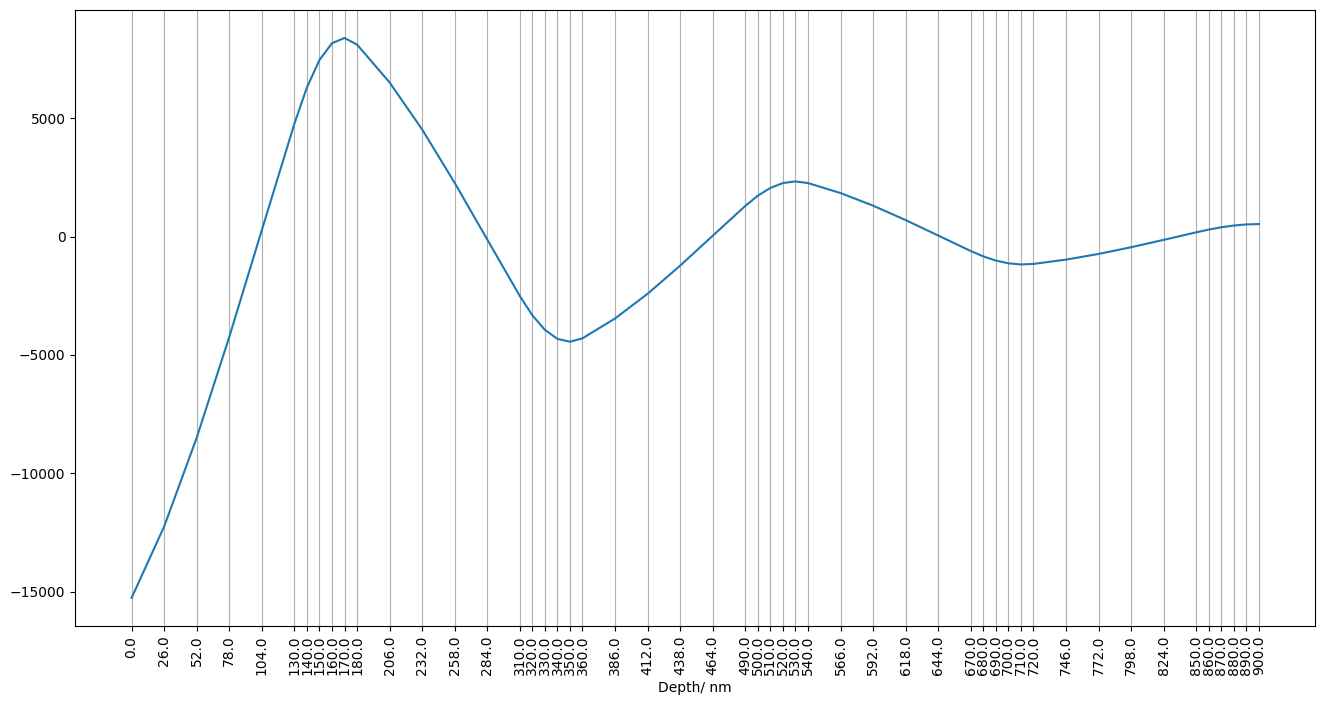

In [24]:
empty_stack()
def field_distribution_backward(Stack_list, light=Light, resolution: int = 100, eps_clad=float, num_per_period: int = 100):


  temp_m = M_matrix(stack_list = Stacking_list, light = light)

  temp_t_light = stack_calculation(M_hat = temp_m, light = light)
  wl = temp_t_light.wl
  F_list = []

  kx_c = (2*np.pi*np.sqrt(eps_clad)*np.cos(np.radians(temp_t_light.angle)))/(wl)

  if light.mode == "TE":
    alpha_c = 1.0
  elif light.mode == "TM":
    alpha_c = 1.0/eps_clad

  F_t = temp_t_light.F
  Stack_list.reverse()
  interation_stack_list = []
  total_depth = 0
  depth_list = [0]
  for stack in Stack_list:
    stack_piece_eps = stack.eps
    stack_piece_thickness = stack.thickness/resolution
    

    for i in range(resolution):
      piece = Stack(eps = stack_piece_eps,
                    thickness = stack_piece_thickness)
      
      interation_stack_list.append(piece)
      total_depth += stack_piece_thickness

      depth_list.append(total_depth)

      #print(piece.eps, piece.thickness, piece.thickness/stack.thickness)

  output = F_t * np.array([[1],[1j * kx_c * alpha_c]])
  for piece in interation_stack_list:

    output =  np.matmul(np.linalg.inv(M_matrix(stack_list = [piece], light = temp_t_light)), output)
    F_list.append((output[0][0]))
  
  
  F_list.reverse()
  F_list.append(temp_t_light.F)
  
  depth_list.reverse()
  depth_list = np.array([float(format((total_depth - i) * 1e9,"0.2E"))  for i in depth_list])

  fig,ax = plt.subplots(figsize = (16,8))
  
  line, = ax.plot(depth_list , np.real(np.array(F_list)))


  def animate(time):
    omega = (C_0 * 1e-14 * 2 * np.pi)/(light.wl * 3 * num_per_period)
    line.set_ydata(np.real(np.array(F_list) * np.exp(-1j * time * omega)))
    return line,

  plt.xticks(depth_list )
  plt.grid(axis = 'x')
  ax.set(xlabel = 'Depth/ nm')
  ax.set_xticklabels(ax.get_xticks(), rotation = 90)
  
  

  ani = animation.FuncAnimation(
      fig, animate, frames = num_per_period, interval = 1000
  )
  
  #plt.show()
  #ani.save("movie.mp4")
  return ani



for i in range(5):
  add_stack(eps_1, f'@{d_1}')
  add_stack(eps_2, f'@{d_2}')


Field_ani = field_distribution_backward(Stack_list = Stacking_list,
                                        light = create_light(mode = "TE", wl = 1000),
                                        eps_clad = eps_clad,
                                        resolution = 5,
                                        num_per_period = 50)



empty_stack()

In [25]:
Field_ani